In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from jupyterthemes import jtplot
from IPython.core.debugger import Tracer
jtplot.style()

In [15]:
# Helper functions
def clip_roll(piano_roll, time_steps=50):
    samples = []
    num_samples = int(piano_roll.shape[1] / time_steps)
    for i in range(num_samples):
        start_idx = time_steps*i
        end_idx = (time_steps*(i+1))
        samples.append(piano_roll[:,start_idx:end_idx])
    return samples   

def create_samples(load_root, time_steps=50, verbose=False):
    samples = []
    for (dirpath, dirnames, filenames) in os.walk(load_root):
        for file in filenames:
            if file.endswith('.npy'):
                load_filepath = os.path.join(dirpath,file)
                if verbose:
                    print(load_filepath)
                piano_roll = np.load(load_filepath).T
                samples = samples + clip_roll(piano_roll,time_steps=time_steps)

    return np.stack(samples)

def feed_dict(batch_size):
    indeces = np.random.randint(num_train_samples, size=batch_size)
    return {X: np.take(samples, indeces, axis=0)}

In [16]:
# X \in {0,1}^{batch_size, dim_x, time_steps}
time_steps = 10 #TEST
x_in_dim = 88
z_dim = 20 #TEST
num_hidden_units = 500
batch_size = 2#100 #TEST
#learning_rate = 5*1e-6
beta_1 = 0.05
beta_2 = 0.001
num_epochs = 400
starter_learning_rate = 1e-4
decay_rate = .6

load_root = './MIDI_Data_PianoRolls/Nottingham/train/'
samples = create_samples(load_root, time_steps=time_steps, verbose=False)
num_train_samples = 10 #TEST #samples.shape[0] #TEST only pick 20 samples and overfit

In [17]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(batch_size, x_in_dim, time_steps))

# time_slices containts input x at time t across batches.
x_in = time_steps * [None]
x_out = time_steps * [None]
h_enc = time_steps * [None]
h_dec = (time_steps + 1) * [None]

for t in range(time_steps):
    x_in[t] = tf.squeeze(tf.slice(X,begin=[0,0,t],size=[-1,-1,1]),axis=2)

###### Encoder network ###########
with tf.variable_scope('encoder_rnn'):
    cell_enc = tf.nn.rnn_cell.BasicRNNCell(num_hidden_units,activation=tf.nn.tanh)
    h_enc[0] = tf.zeros([batch_size,num_hidden_units], dtype=tf.float32) # Initial state is 0

    # h_t+1 = tanh(Wenc*h_t + Win*x_t+1 + b )
    #Most basic RNN: output = new_state = act(W * input + U * state + B).
    #https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/python/ops/rnn_cell_impl.py
    for t in range(time_steps-1):
        _ , h_enc[t+1] = cell_enc(inputs=x_in[t+1], state=h_enc[t])


mu_enc = tf.layers.dense(h_enc[-1], z_dim, activation=None, name='mu_enc')
log_sigma_enc = tf.layers.dense(h_enc[-1], z_dim, activation=None, name='log_sigma_enc')

###### Reparametrize ##############
eps = tf.random_normal(tf.shape(log_sigma_enc))
z = mu_enc + tf.exp(log_sigma_enc) * eps

##### Decoder network ############
with tf.variable_scope('decoder_rnn'):
    W_out = tf.get_variable('W_out',shape=[num_hidden_units, x_in_dim])
    b_out = tf.get_variable('b_out',shape=[x_in_dim])
    
    cell_dec = tf.nn.rnn_cell.BasicRNNCell(num_hidden_units,activation=tf.nn.tanh)
    h_dec[0] = tf.layers.dense(z, num_hidden_units, activation=tf.nn.tanh)
    
    for t in range(time_steps):
        x_out[t] = tf.nn.sigmoid(tf.matmul(h_dec[t], W_out) + b_out)
        if t < time_steps - 1:
            _, h_dec[t+1] = cell_dec(inputs=x_out[t], state=h_dec[t])

##### Loss #####################
with tf.variable_scope('loss'):
    # Latent loss: -KL[q(z|x)|p(z)]
    with tf.variable_scope('latent_loss'):
        sigma_sq_enc = tf.square(tf.exp(log_sigma_enc))
        latent_loss = -.5 * tf.reduce_mean(tf.reduce_sum((1 + tf.log(1e-10 + sigma_sq_enc)) - tf.square(mu_enc) - sigma_sq_enc, axis=1),axis=0)
        latent_loss_summ = tf.summary.scalar('latent_loss',latent_loss)
        
    # Reconstruction Loss: log(p(x|z))    
    with tf.variable_scope('recon_loss'):    
        for i in range(time_steps):
            if i == 0:
                recon_loss_ = x_in[i] * tf.log(1e-10 + x_out[i]) + (1 - x_in[i]) * tf.log(1e-10+1-x_out[i])
            else:
                recon_loss_ += x_in[i] * tf.log(1e-10 + x_out[i]) + (1 - x_in[i]) * tf.log(1e-10+1-x_out[i])
            
        #collapse the loss, mean across a sample across all x_dim and time points, mean over batches
        recon_loss = -tf.reduce_mean(tf.reduce_mean(recon_loss_/(time_steps),axis=1),axis=0)

            
    recon_loss_summ = tf.summary.scalar('recon_loss', recon_loss)
                
    with tf.variable_scope('total_loss'):
        total_loss = latent_loss + recon_loss
    
    total_loss_summ = tf.summary.scalar('total_loss', total_loss)

global_step = tf.Variable(0,name='global_step') 
epoch_num = tf.Variable(1, name='epoch_num', trainable=False, dtype=tf.int32)
increment_epoch_num_op = tf.assign(epoch_num, epoch_num+1)


learning_rate = tf.train.exponential_decay(starter_learning_rate, epoch_num, num_epochs, decay_rate, staircase=False)
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta_1, beta2=beta_2).minimize(total_loss,global_step=global_step)    
scalar_summaries = tf.summary.merge([latent_loss_summ, recon_loss_summ, total_loss_summ])
#image_summaries = tf.summary.merge()

train_summary_writer = tf.summary.FileWriter('./logs', tf.get_default_graph())

In [18]:
num_batches = int(num_train_samples/batch_size)
global_step_op = tf.train.get_global_step()


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        epoch_loss = 0.
        epoch_latent_loss = 0.
        for batch in range(num_batches):
            batch_num = sess.run(global_step_op)
            _ , loss, scalar_summaries_, x_out_, x_in_,learning_rate_,latent_loss_ = sess.run([train_step, total_loss, scalar_summaries, x_out, x_in,learning_rate, latent_loss],feed_dict=feed_dict(batch_size))
            train_summary_writer.add_summary(scalar_summaries_, global_step=batch_num)
            epoch_loss += loss
            epoch_latent_loss += latent_loss_
            
            sigma_sq_enc_ = sess.run(sigma_sq_enc, feed_dict=feed_dict(batch_size))
            #Tracer()()
            
            
            #print('Epoch Loss: {}'.format(loss))
        print('Average loss epoch {0}: {1}'.format(epoch, epoch_loss/num_batches)) 
        print('Average latent loss epoch {0}: {1}'.format(epoch, epoch_latent_loss/num_batches)) 
        print('Learning Rate {}'.format(learning_rate_))
        sess.run(increment_epoch_num_op)

Average loss epoch 0: 2.0510775089263915
Average latent loss epoch 0: 1.3754248142242431
Learning Rate 9.987236990127712e-05
Average loss epoch 1: 0.8320347428321838
Average latent loss epoch 1: 0.24253873527050018
Learning Rate 9.974491695174947e-05
Average loss epoch 2: 0.6886101484298706
Average latent loss epoch 2: 0.177860289812088
Learning Rate 9.96176095213741e-05
Average loss epoch 3: 0.5909326195716857
Average latent loss epoch 3: 0.1512476921081543
Learning Rate 9.949047671398148e-05
Average loss epoch 4: 0.5765146017074585
Average latent loss epoch 4: 0.19687959253787995
Learning Rate 9.936349670169875e-05
Average loss epoch 5: 0.48565603494644166
Average latent loss epoch 5: 0.1591309756040573
Learning Rate 9.923669131239876e-05
Average loss epoch 6: 0.3961814343929291
Average latent loss epoch 6: 0.10597045421600342
Learning Rate 9.911003144225106e-05
Average loss epoch 7: 0.35255649089813235
Average latent loss epoch 7: 0.09430299401283264
Learning Rate 9.898354619508609e

Average loss epoch 64: 0.15122565925121306
Average latent loss epoch 64: 0.021008649468421937
Learning Rate 9.203427180182189e-05
Average loss epoch 65: 0.14355795085430145
Average latent loss epoch 65: 0.02187764346599579
Learning Rate 9.191680874209851e-05
Average loss epoch 66: 0.14490315318107605
Average latent loss epoch 66: 0.01846420168876648
Learning Rate 9.179949847748503e-05
Average loss epoch 67: 0.14158032238483428
Average latent loss epoch 67: 0.01946718990802765
Learning Rate 9.168234100798145e-05
Average loss epoch 68: 0.14691197574138642
Average latent loss epoch 68: 0.02359512448310852
Learning Rate 9.156532905763015e-05
Average loss epoch 69: 0.15333107560873033
Average latent loss epoch 69: 0.02956419885158539
Learning Rate 9.144846990238875e-05
Average loss epoch 70: 0.15082390904426574
Average latent loss epoch 70: 0.023790210485458374
Learning Rate 9.133176354225725e-05
Average loss epoch 71: 0.14655233323574066
Average latent loss epoch 71: 0.02331932485103607
Le

Average loss epoch 127: 0.12930529415607453
Average latent loss epoch 127: 0.013430482149124146
Learning Rate 8.491968765156344e-05
Average loss epoch 128: 0.12844892144203185
Average latent loss epoch 128: 0.018895718455314636
Learning Rate 8.481131226290017e-05
Average loss epoch 129: 0.12184174656867981
Average latent loss epoch 129: 0.00929492712020874
Learning Rate 8.470306784147397e-05
Average loss epoch 130: 0.11969386488199234
Average latent loss epoch 130: 0.014370301365852356
Learning Rate 8.459496893920004e-05
Average loss epoch 131: 0.12058843970298767
Average latent loss epoch 131: 0.009424114227294922
Learning Rate 8.448700100416318e-05
Average loss epoch 132: 0.12385477721691132
Average latent loss epoch 132: 0.012587159872055054
Learning Rate 8.437917858827859e-05
Average loss epoch 133: 0.10995623916387558
Average latent loss epoch 133: 0.011628809571266174
Learning Rate 8.427148713963106e-05
Average loss epoch 134: 0.10149878412485122
Average latent loss epoch 134: 0.

Average loss epoch 190: 0.09930073320865632
Average latent loss epoch 190: 0.008691501617431641
Learning Rate 7.835509313736111e-05
Average loss epoch 191: 0.09532948732376098
Average latent loss epoch 191: 0.006566011905670166
Learning Rate 7.825509237591177e-05
Average loss epoch 192: 0.09465941786766052
Average latent loss epoch 192: 0.006733420491218567
Learning Rate 7.815521530574188e-05
Average loss epoch 193: 0.09571240693330765
Average latent loss epoch 193: 0.00976661741733551
Learning Rate 7.805546920280904e-05
Average loss epoch 194: 0.0959065705537796
Average latent loss epoch 194: 0.010163754224777222
Learning Rate 7.795585406711325e-05
Average loss epoch 195: 0.09567812085151672
Average latent loss epoch 195: 0.009456098079681396
Learning Rate 7.78563626226969e-05
Average loss epoch 196: 0.09730214178562165
Average latent loss epoch 196: 0.00655631422996521
Learning Rate 7.775700214551762e-05
Average loss epoch 197: 0.08483879566192627
Average latent loss epoch 197: 0.005

Average loss epoch 253: 0.08030912801623344
Average latent loss epoch 253: 0.0067033559083938595
Learning Rate 7.229796028696e-05
Average loss epoch 254: 0.10060711950063705
Average latent loss epoch 254: 0.008674317598342895
Learning Rate 7.220569386845455e-05
Average loss epoch 255: 0.08769882321357728
Average latent loss epoch 255: 0.004904738068580628
Learning Rate 7.21135365893133e-05
Average loss epoch 256: 0.08127294480800629
Average latent loss epoch 256: 0.005068260431289673
Learning Rate 7.202150300145149e-05
Average loss epoch 257: 0.09476274996995926
Average latent loss epoch 257: 0.005749252438545227
Learning Rate 7.192958582891151e-05
Average loss epoch 258: 0.0809779554605484
Average latent loss epoch 258: 0.0038651436567306518
Learning Rate 7.183778507169336e-05
Average loss epoch 259: 0.08526166677474975
Average latent loss epoch 259: 0.006369754672050476
Learning Rate 7.174610072979704e-05
Average loss epoch 260: 0.08402476757764817
Average latent loss epoch 260: 0.00

Average loss epoch 316: 0.08462637215852738
Average latent loss epoch 316: 0.0062766939401626585
Learning Rate 6.670906441286206e-05
Average loss epoch 317: 0.07513352781534195
Average latent loss epoch 317: 0.004522556066513061
Learning Rate 6.66239284328185e-05
Average loss epoch 318: 0.08381607383489609
Average latent loss epoch 318: 0.005536183714866638
Learning Rate 6.653890159213915e-05
Average loss epoch 319: 0.08083256483078002
Average latent loss epoch 319: 0.0037731558084487917
Learning Rate 6.64539766148664e-05
Average loss epoch 320: 0.0836752787232399
Average latent loss epoch 320: 0.004055127501487732
Learning Rate 6.636916805291548e-05
Average loss epoch 321: 0.07983216941356659
Average latent loss epoch 321: 0.0036393433809280397
Learning Rate 6.628446135437116e-05
Average loss epoch 322: 0.07236837148666382
Average latent loss epoch 322: 0.004128482937812805
Learning Rate 6.619986379519105e-05
Average loss epoch 323: 0.07597070932388306
Average latent loss epoch 323: 0

Average loss epoch 378: 0.07300230413675309
Average latent loss epoch 378: 0.002866929769515991
Learning Rate 6.163087527966127e-05
Average loss epoch 379: 0.06910627186298371
Average latent loss epoch 379: 0.001651439070701599
Learning Rate 6.155222217785195e-05
Average loss epoch 380: 0.07600217163562775
Average latent loss epoch 380: 0.0034081369638442995
Learning Rate 6.14736636634916e-05
Average loss epoch 381: 0.07452253848314286
Average latent loss epoch 381: 0.0023041486740112303
Learning Rate 6.139519973658025e-05
Average loss epoch 382: 0.07864928394556045
Average latent loss epoch 382: 0.004288312792778015
Learning Rate 6.131685222499073e-05
Average loss epoch 383: 0.07080718576908111
Average latent loss epoch 383: 0.003179189562797546
Learning Rate 6.123859202489257e-05
Average loss epoch 384: 0.08409742563962937
Average latent loss epoch 384: 0.003989794850349426
Learning Rate 6.116044096415862e-05
Average loss epoch 385: 0.07486334517598152
Average latent loss epoch 385: 

In [19]:
def plot_x_io(x, samp_num):
    x_arr = np.asarray(x)
    plt.imshow(x_arr[:,samp_num,:].T)
    plt.show()

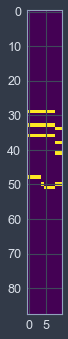

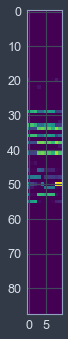

In [21]:
plot_x_io(x_in_, 0)
plot_x_io(x_out_, 0)
